# File Description

This notebook contains the most up-to-date version of the pilot model for total water level on Tarawa, currently for only two locations (one lagoon side and one ocean side).

Currently needs work:
- Incorporating MEI into network
- Adjusting the binning of the MSL distributions to account for future SLR
- Adding SLR projections as evidence option

<cite data-cite="2344856/I2LE4LVY"></cite>


<div class="cite2c-biblio"></div>

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from colormap import rgb2hex
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython
from folium.plugins import FloatImage

from BNModel import BNModel

from preprocessing_all_points import *
from preprocessing_points_spatially import *

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [3]:
# ### set location of file storage
# folder = 'BN_antonio_data'
# try:
#     os.makedirs(folder)
# except FileExistsError:
#     pass

# Data Prep

## Preprocessing

In [4]:
# Import and preprocess data
df_ocean,df_lagoon = preprocessing_points_spatially()
df_lagoon,lagoon_data_dict = BN_Antonio_preprocessing_lagoon(df_lagoon)
df_ocean,ocean_data_dict = BN_Antonio_preprocessing_ocean(df_ocean)

(array([1.3586e+04, 8.0251e+04, 4.3724e+04, 2.5346e+04, 9.6460e+03,
        2.6420e+03, 5.7400e+02, 1.1400e+02, 1.5000e+01, 5.0000e+00]),
 array([0.04467482, 0.2615222 , 0.47836957, 0.69521694, 0.91206431,
        1.12891168, 1.34575905, 1.56260642, 1.7794538 , 1.99630117,
        2.21314854]),
 <BarContainer object of 10 artists>)

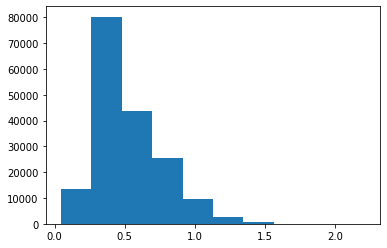

In [5]:
plt.hist(df_ocean.WL_wave_comp)

(array([3.3925e+04, 2.3133e+04, 1.1940e+04, 4.9710e+03, 1.5660e+03,
        4.7500e+02, 1.2600e+02, 3.8000e+01, 6.0000e+00, 3.0000e+00]),
 array([0.50000016, 0.671315  , 0.84262983, 1.01394467, 1.18525951,
        1.35657435, 1.52788919, 1.69920402, 1.87051886, 2.0418337 ,
        2.21314854]),
 <BarContainer object of 10 artists>)

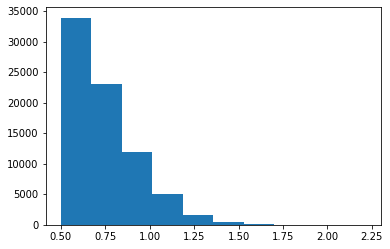

In [6]:
plt.hist(df_ocean[df_ocean['WL_wave_comp']>0.5].WL_wave_comp)

(array([1.4418e+05, 1.2610e+03, 2.8950e+03, 1.7320e+03, 5.7900e+02,
        2.0100e+02, 4.5000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00]),
 array([-0.07057976,  0.08538569,  0.24135114,  0.39731659,  0.55328204,
         0.70924749,  0.86521294,  1.02117839,  1.17714384,  1.33310929,
         1.48907474]),
 <BarContainer object of 10 artists>)

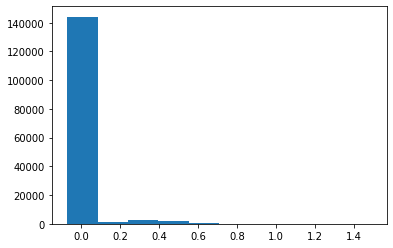

In [7]:
plt.hist(df_lagoon.WL_wave_comp)

(array([1.021e+03, 2.548e+03, 1.908e+03, 6.220e+02, 3.000e+02, 8.700e+01,
        1.900e+01, 9.000e+00, 1.000e+00, 1.000e+00]),
 array([0.10003677, 0.23894057, 0.37784437, 0.51674816, 0.65565196,
        0.79455576, 0.93345955, 1.07236335, 1.21126715, 1.35017094,
        1.48907474]),
 <BarContainer object of 10 artists>)

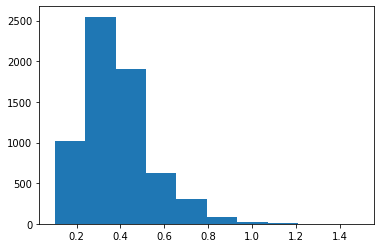

In [8]:
plt.hist(df_lagoon[df_lagoon['WL_wave_comp']>0.1].WL_wave_comp)

In [9]:
# Reprocess the data with the new ranges
df_lagoon,lagoon_data_dict = BN_Antonio_preprocessing_lagoon(df_lagoon[df_lagoon['WL_wave_comp']>0.1])
df_ocean,ocean_data_dict = BN_Antonio_preprocessing_ocean(df_ocean[df_ocean['WL_wave_comp']>0.5])

/src/Submodels/SM4_water_level/preprocessing_all_points.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Pto_lagoon['WL_wave_comp'] = df_Pto_lagoon['TWL']-df_Pto_lagoon['Tide']-df_Pto_lagoon['MSL']
/src/Submodels/SM4_water_level/preprocessing_all_points.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Pto_ocean['WL_wave_comp'] = df_Pto_ocean['TWL']-df_Pto_ocean['Tide']-df_Pto_ocean['MSL']


In [10]:
df_lagoon.reset_index(inplace=True)
df_ocean.reset_index(inplace=True)

## Create Variable Dictionary

In [11]:

#### Don't include spaces in bin names. if no discretisation, just leave out that key
lagoon_model_dict = {
    'variables':{
        'wind_u':{
            'label':'Wind u vector (m/s)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'wind_v':{
            'label':r'Wind v vector (m/s)',
            'discretisation':{
                'n_bins':5,
                'strategy':'uniform',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'Hs_offshore':{
            'label':'Offshore wave height (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'Tm_offshore':{
            'label':'Offshore wave period (s)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'Dir_offshore':{
            'label':r'Offshore wave direction (degrees)',
            'discretisation':{
                'n_bins':4,
                'strategy':'kmeans',
                'bin_names':['N','E','S','W']
            },
            'child_nodes':['WL_wave_comp']
        },
        'WL_wave_comp':{
            'label':'Water level from wave component (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh'],
#                 'bin_edges':np.arange(0,0.5,(0.5-0)/6)
            },
            'child_nodes':[]
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}
ocean_model_dict = {
   'variables':{
       'Tm_offshore':{
            'label':'Wave period offshore (s)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
       'Tide':{
            'label':'Tide (m)',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['WL_wave_comp']
        },
       'MSL':{
            'label':'MSL (m)',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['WL_wave_comp']
        },
        'Hs_offshore':{
            'label':'Wave height offshore (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'Dir_offshore':{
            'label':'Wave direction offshore (degrees)',
            'discretisation':{
                'n_bins':4,
                'strategy':'kmeans',
                'bin_names':['N','E','S','W']
            },
            'child_nodes':['WL_wave_comp']
        },
        'WL_wave_comp':{
            'label':'Water level from wave component (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh'],
#                 'bin_edges':np.arange(0.13,0.9,(0.9-.13)/6)
            },
            'child_nodes':[]
        },
        'reef_width':{
            'label':'Reef width (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'reef_depth':{
            'label':'Reef depth (m)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'forereef_slope':{
            'label':'Fore reef slope (degrees)',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['WL_wave_comp']
        },
        'shore_dir':{
            'label':'Shoreline direction (degrees)',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['NE','S','NW']
            },
            'child_nodes':['WL_wave_comp']
        }
   },
    'training_frac':0.8,
    'bootstrap_reps':1
}


## Bootstrapping the data

In [12]:
# Bootstrap the data, and add it to the model_dict
lagoon_model_dict = BNModel().bootstrap_data(lagoon_model_dict,lagoon_data_dict,df_lagoon)

ocean_model_dict = BNModel().bootstrap_data(ocean_model_dict,ocean_data_dict,df_ocean)

## Discretise the data

In [13]:
# Discretise the data
lagoon_file_label = "lagoon"
ocean_file_label = "ocean"

lagoon_model_dict = BNModel().discretiser(lagoon_model_dict,[])
ocean_model_dict = BNModel().discretiser(ocean_model_dict,[])

In [14]:
# lagoon_model_dict['variables']['MEI']

In [15]:
# lagoon_disc_fig = BNModel().plot_discretiser(lagoon_model_dict,[])

In [16]:
# ocean_disc_fig = BNModel().plot_discretiser(ocean_model_dict,[])

## Save the data

In [17]:
BNModel().save_dataset(lagoon_model_dict,lagoon_file_label)
BNModel().save_dataset(ocean_model_dict,ocean_file_label)

# Create BN Model

In [18]:
# Create the BN
lagoon_model_dict = BNModel().create_SM(lagoon_model_dict,lagoon_file_label)

In [19]:
ocean_model_dict = BNModel().create_SM(ocean_model_dict,ocean_file_label)

## View Conditional Probability tables

In [20]:
# Get conditional probs tables
BNModel().get_conditional_prob_table(lagoon_model_dict,'WL_wave_comp')

wind_u         VeryLow                                               ...  \
wind_v         VeryLow                                               ...   
Hs_offshore    VeryLow                                               ...   
Tm_offshore    VeryLow                 Low                 Mid       ...   
Dir_offshore         N    E    S    W    N    E    S    W    N    E  ...   
WL_wave_comp                                                         ...   
High          0.235717  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  ...   
Low           0.275153  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  ...   
Mid           0.094958  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  ...   
VeryHigh      0.055740  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  ...   
VeryLow       0.338431  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  ...   

wind_u       VeryHigh                                                   
wind_v       VeryHigh                                                   
Hs_offshore  VeryHigh                                                   
Tm_offshore       Mid      High                VeryHigh                 
Dir_offshore        S    W    N    E    S    W        N    E    S    W  
WL_wave_comp                                                            
High              0.2  0.2  0.2  0.2  0.2  0.2      0.0  0.2  0.2  0.2  
Low               0.2  0.2  0.2  0.2  0.2  0.2      0.0  0.2  0.2  0.2  
Mid               0.2  0.2  0.2  0.2  0.2  0.2      0.0  0.2  0.2  0.2  
VeryHigh          0.2  0.2  0.2  0.2  0.2  0.2      1.0  0.2  0.2  0.2  
VeryLow           0.2  0.2  0.2  0.2  0.2  0.2      0.0  0.2  0.2  0.2  

[5 rows x 2500 columns]

In [21]:
# Get conditional probs tables
df_CPT_MSL = BNModel().get_conditional_prob_table(ocean_model_dict,'WL_wave_comp')

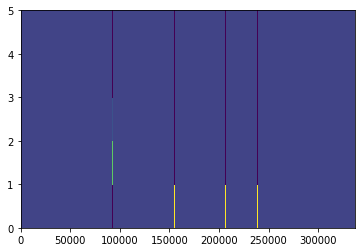

In [22]:
df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','Mid','High','VeryHigh']]

plt.pcolor(df_CPT_MSL)

In [23]:
df_CPT_MSL

Tm_offshore      VeryLow                                                     \
Tide                 Low                                                      
MSL                  Low                                                      
Hs_offshore      VeryLow                                                      
Dir_offshore           N                                                      
reef_width       VeryLow                                                      
reef_depth       VeryLow                                                      
forereef_slope   VeryLow             Low                 Mid           High   
shore_dir             NE    S   NW    NE    S   NW        NE    S   NW   NE   
WL_wave_comp                                                                  
VeryLow         0.311881  0.2  0.2  0.20  0.2  0.2  0.161290  0.2  0.2  0.0   
Low             0.021065  0.2  0.2  0.05  0.2  0.2  0.322581  0.2  0.2  0.5   
Mid             0.261458  0.2  0.2  0.30  0.2  0.2  0.193548  0.2  0.2  0.0   
High            0.250365  0.2  0.2  0.30  0.2  0.2  0.225806  0.2  0.2  0.5   
VeryHigh        0.155231  0.2  0.2  0.15  0.2  0.2  0.096774  0.2  0.2  0.0   

Tm_offshore     ... VeryHigh                                                   
Tide            ...     High                                                   
MSL             ...     High                                                   
Hs_offshore     ... VeryHigh                                                   
Dir_offshore    ...        W                                                   
reef_width      ... VeryHigh                                                   
reef_depth      ... VeryHigh                                                   
forereef_slope  ...      Low  Mid           High           VeryHigh            
shore_dir       ...       NW   NE    S   NW   NE    S   NW       NE    S   NW  
WL_wave_comp    ...                                                            
VeryLow         ...      0.2  0.2  0.2  0.2  0.2  0.2  0.2      0.2  0.2  0.2  
Low             ...      0.2  0.2  0.2  0.2  0.2  0.2  0.2      0.2  0.2  0.2  
Mid             ...      0.2  0.2  0.2  0.2  0.2  0.2  0.2      0.2  0.2  0.2  
High            ...      0.2  0.2  0.2  0.2  0.2  0.2  0.2      0.2  0.2  0.2  
VeryHigh        ...      0.2  0.2  0.2  0.2  0.2  0.2  0.2      0.2  0.2  0.2  

[5 rows x 337500 columns]

# Set Evidence

In [24]:
lagoon_evidence_dict = {
    'wind_u':[0.05,0.1,0.01,0.01,0.01],
    'wind_v':[0.05,0.1,0.01,0.01,0.01,0.01]
}

ocean_evidence_dict = {
    'Hs_offshore':[1,0,0,0,0]
}

In [25]:
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,lagoon_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,ocean_evidence_dict)

# Update beliefs based on evidence

In [26]:
# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)
ocean_model_dict = BNModel().update_evidence(ocean_model_dict)

# BN Visualisation

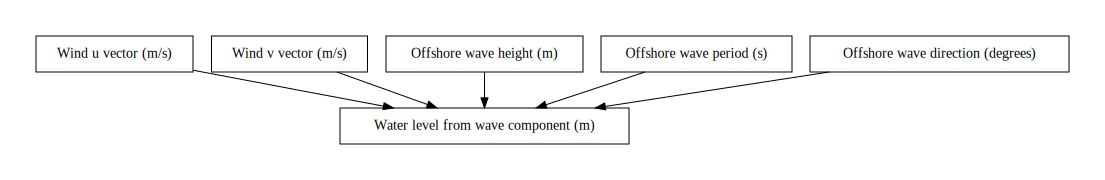

In [27]:

# Set up graph
graph_lagoon = BNModel().create_BN_graph()

# Create nodes of the graph
graph_lagoon,lagoon_model_dict = BNModel().create_nodes(graph_lagoon,lagoon_model_dict,0)

# Create arcs between nodesb
graph_lagoon = BNModel().create_arcs(graph_lagoon,lagoon_model_dict)

# Save as dot file
graph_lagoon.render(filename='graph_lagoon',format='png')

# Plot the graph
graph_lagoon


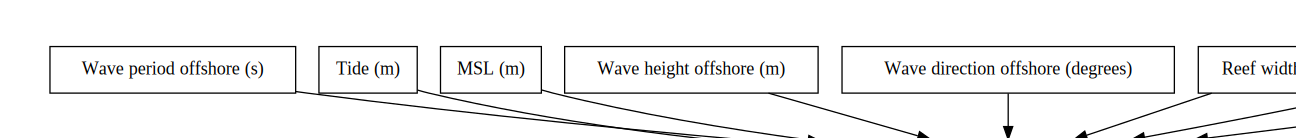

In [28]:

# Set up graph
graph_ocean = BNModel().create_BN_graph()

# Create nodes of the graph
graph_ocean,ocean_model_dict = BNModel().create_nodes(graph_ocean,ocean_model_dict,0)

# Create arcs between nodesb
graph_ocean = BNModel().create_arcs(graph_ocean,ocean_model_dict)

# Save as dot file
graph_ocean.render(filename='graph_ocean',format='png')

# Plot the graph
graph_ocean

# Model Validation

In [29]:
def create_validator(pysmile_dict,node_name,rep):
    '''
    Creates a validator function for this rep. Used in other functions here
    inputs:
        - dictionary of pysmile objects
        - node_name: name of the node to be validated
    outputs:
        - validator function
    '''

    net = pysmile_dict['net']
    ds_testing = pysmile_dict['ds_testing']

    # Setup  the validator
    matching = ds_testing.match_network(net)
    validator = pysmile.learning.Validator(net, ds_testing, matching)

    # get the id of the node
    classNodeHandle = net.get_node(node_name)

    # Add total water level node to the validator
    validator.add_class_node(classNodeHandle)

    # Get the expectation maximisation (EM) function for parameter estimation
    em = pysmile.learning.EM()

    # Using expectation-maximisation, determine the accuracy using k_fold (5) cross validation
    validator.k_fold(em, 5)

    return(validator)

In [30]:
def def_confusion_matrix(model_dict,node_name,rep):
    '''
    Function used for evaluating the performance of the BN across all variables using a confusion matrix for a single rep.
    Args:
        - Model dictionary, which has all the model vars in it
        - node_name: str of the name of the variable that you want to analyse with the confusion matrix
        - rep: the bootstrap iteration that you want to analyse
    Returns:
        - figure and axes matplotlib.pyplot objects


    '''

    # Get the network for this iteration
    net = model_dict['model'][rep]['net']

    # get the id of the node
    classNodeHandle = net.get_node(node_name)

    # Create the validator
    validator = create_validator(model_dict['model'][rep],node_name,rep)

    # Get the confusion matrix 
    confusion_matrix = validator.get_confusion_matrix(classNodeHandle)
    
    confusion_matrix = [x[1:] for x in confusion_matrix[1:]]

    # Setup the figure
    fig, ax1 = plt.subplots(figsize=(10,10))
    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 20}

    matplotlib.rc('font', **font)

    # Plot the correlation matrix of the pandas dataframe of all variables except time
    plot_output = ax1.matshow(confusion_matrix,cmap='Blues')

    # Format axes
    ax1.set_xticks(np.arange(0,len(net.get_outcome_ids(classNodeHandle)),1))
    ax1.set_yticks(np.arange(0,len(net.get_outcome_ids(classNodeHandle)),1))
    ax1.set_xticklabels(net.get_outcome_ids(classNodeHandle))
    ax1.set_yticklabels(net.get_outcome_ids(classNodeHandle))
    plt.xticks(rotation=90)
    ax1.set_ylabel('Predicted values')
    ax1.set_xlabel('Actual values')
    ax1.xaxis.set_label_position('top')
    ax1.set_title('Confusion matrix'.format(node_name))

    # Add legend
    cb = fig.colorbar(plot_output)
    cb.ax.set_ylabel('Data points')

    return(confusion_matrix)

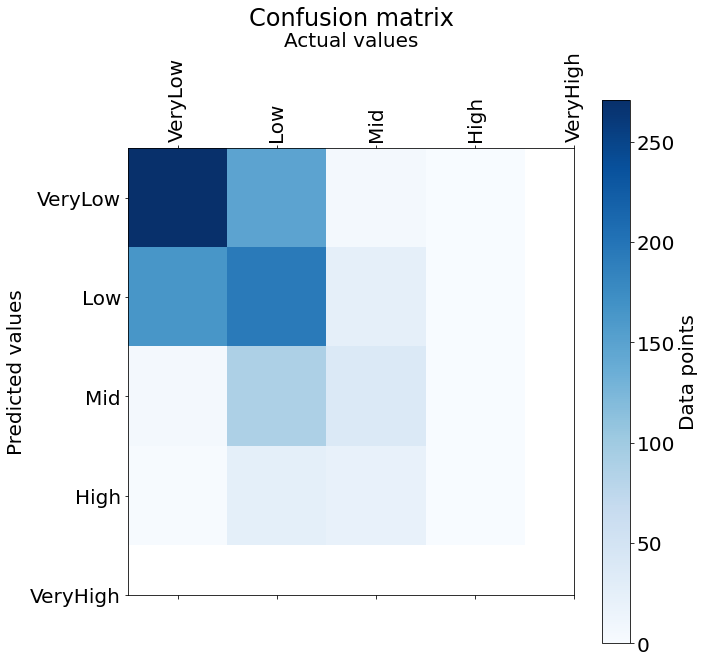

In [31]:
matrix = def_confusion_matrix(lagoon_model_dict,"WL_wave_comp",0)

{(0, 'VeryLow'): 0.5333333333333333, (0, 'Low'): 0.5915789473684211, (0, 'Mid'): 0.4801980198019802, (0, 'High'): 0.2518518518518518, (0, 'VeryHigh'): 0.0}


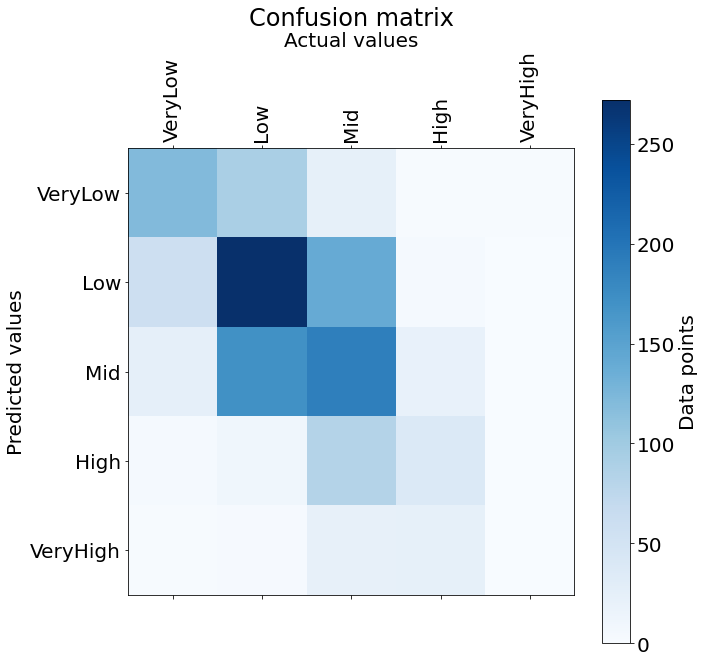

In [32]:
### Research picking number of kfolds 

lagoon_acc_dict = BNModel().get_accuracies(lagoon_model_dict,"WL_wave_comp")

print(lagoon_acc_dict)

fig, ax = BNModel().confusion_matrix(lagoon_model_dict,"WL_wave_comp",0)

{(0, 'VeryLow'): 0.6268436578171092, (0, 'Low'): 0.32305336832895887, (0, 'Mid'): 0.2148786717752235, (0, 'High'): 0.12999403697078116, (0, 'VeryHigh'): 0.03009259259259259}


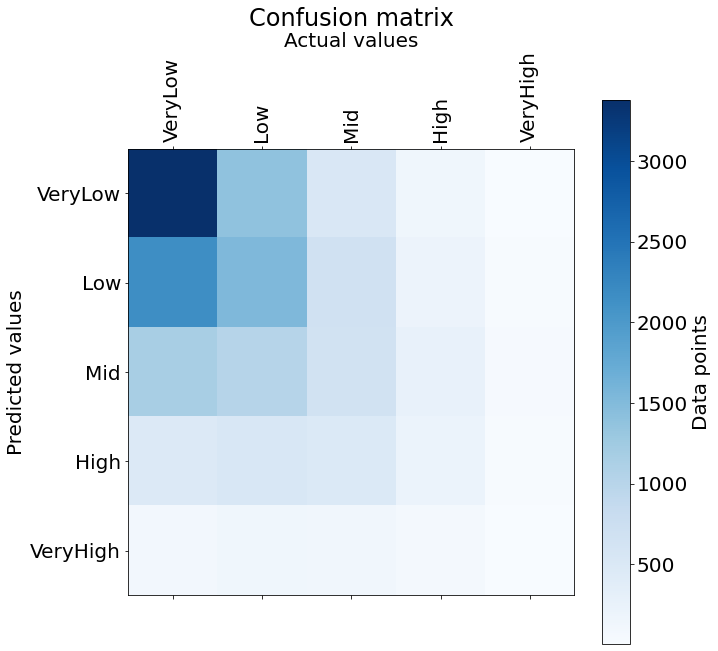

In [33]:

ocean_acc_dict = BNModel().get_accuracies(ocean_model_dict,"WL_wave_comp")

print(ocean_acc_dict)

fig, ax = BNModel().confusion_matrix(ocean_model_dict,"WL_wave_comp",0)

# Sensitivity Analysis

## Lagoon

### Tide on TWL

# MSL Priors based on Future Projections

## Get the distribution of MSL data currently

In [34]:
# def grouping_bins(data):
#     grouped_dict = {}

#     for bin_name in np.unique(data):
#         grouped_dict.update({
#             bin_name:len(data[data==bin_name])
#         })
        
#     df_grouped = pd.DataFrame.from_dict(grouped_dict,orient='index')
    
#     return(df_grouped)

In [35]:
# def descretiser(bin_edges,bin_names,data_array):
    
#     discretised_array = np.empty(len(data_array)).astype(str)
    
#     for lower, upper, bin_name in zip(
#         bin_edges[:-1],
#         bin_edges[1:],
#         bin_names):
        
#         discretised_array[(data_array>lower)&(data_array<upper)] = bin_name

#         # Now Include out of bounds values in the upper and lower bins
#         discretised_array[data_array<np.min(bin_edges)] = bin_names[0]
#         discretised_array[data_array>np.max(bin_edges)] = bin_names[-1]
        
#     return(discretised_array)
                    

In [36]:
# # Bin the MSL data
# MSL_data = lagoon_model_dict['variables']['MSL']['training_data'][0]

# # Grouping the bins 
# MSL_bins_grouped = grouping_bins(MSL_data)

# # Put the bins in the right order
# df_MSL_distribution = MSL_bins_grouped.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])

# # Plot the data
# plt.plot(df_MSL_distribution)

## Add the Global average for now

In [37]:
# # Get the preprocessed data to add to
# MSL_training_data_preprocessed = lagoon_model_dict['variables']['MSL']['training_data_preprocessed'][0]
# MSL_testing_data_preprocessed = lagoon_model_dict['variables']['MSL']['testing_data_preprocessed'][0]

# # Print some stats to get an idea of how adding SLR will affect the data
# print(np.min(MSL_training_data_preprocessed))
# print(np.max(MSL_training_data_preprocessed))
# print(np.mean(MSL_training_data_preprocessed))
# print(np.median(MSL_training_data_preprocessed))

In [38]:
# # Based on a 2 mm/yr rate
# mean_SLR_2050 = 2*29/1000
# mean_SLR_2100 = 2*59/1000

# # Get MSLs adjusted for regional sea level rise
# MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
# MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100

In [39]:
# # Using the bins from before, discretise the results
# bin_edges = lagoon_model_dict['variables']['MSL']['bin_edges'][0]
# bin_names = lagoon_model_dict['variables']['MSL']['discretisation']['bin_names']

# # Normalise the data
# df_MSL_2021 = df_MSL_distribution/np.nansum(df_MSL_distribution)

# # Calculated discretised MSL for the scenarios
# MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
# MSL_2050_discretised = descretiser(bin_edges,bin_names,MSL_2050)
# df_MSL_2050 = grouping_bins(MSL_2050_discretised)
# df_MSL_2050 = df_MSL_2050.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
# df_MSL_2050[df_MSL_2050.isna()] = 0.001
# df_MSL_2050 = df_MSL_2050/np.nansum(df_MSL_2050)

# # Calculated discretised MSL for the scenarios
# MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100
# MSL_2100_discretised = descretiser(bin_edges,bin_names,MSL_2100)
# df_MSL_2100 = grouping_bins(MSL_2100_discretised)
# df_MSL_2100 = df_MSL_2100.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
# df_MSL_2100[df_MSL_2100.isna()] = 0.001
# df_MSL_2100 = df_MSL_2100/np.nansum(df_MSL_2100)


### Set evidence of 2050

In [40]:
# # Create dict of evidence
# MSL_2050_evidence_dict = {
#     'MSL':list(df_MSL_2050[0])
# }

# # Add evidence for MSL to the model dict
# lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2050_evidence_dict)
# ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2050_evidence_dict)

# # Set evidence and get beliefs
# lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# # TWL posterior 2050
# TWL_MSL_2050_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
# df_TWL_MSL_2050_posterior = pd.DataFrame.from_dict(TWL_MSL_2050_posterior_dict,orient='index')

In [41]:
# # Create dict of evidence
# MSL_2100_evidence_dict = {
#     'MSL':list(df_MSL_2100[0])
# }

# # Add evidence for MSL to the model dict
# lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2100_evidence_dict)
# ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2100_evidence_dict)

# # Set evidence and get beliefs
# lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# # TWL posterior 2100
# TWL_MSL_2100_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
# df_TWL_MSL_2100_posterior = pd.DataFrame.from_dict(TWL_MSL_2100_posterior_dict,orient='index')

In [42]:
# # get the original data to compare it to
# TWL_training_dict = lagoon_model_dict['variables']['TWL_point_110']['training_data'][0]
# df_TWL_training = grouping_bins(TWL_training_dict)
# df_TWL_training = df_TWL_training.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
# df_TWL_training[df_TWL_training.isna()] = 0.001
# df_TWL_training = df_TWL_training/np.nansum(df_TWL_training)

# # Create an extra set of dfs for data as a fraction of original
# TWL_MSL_2050 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2050_posterior[0])]
# TWL_MSL_2100 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2100_posterior[0])]
# df_TWL_MSL_2050 = pd.DataFrame(TWL_MSL_2050).set_index(0)
# df_TWL_MSL_2100 = pd.DataFrame(TWL_MSL_2100).set_index(0)

In [43]:

# # Set up the figure
# fig = plt.figure(figsize=(10,15))
# fig.subplots_adjust(hspace=0.5)
# ax1 = plt.subplot2grid((3,1),(0,0))
# ax2 = plt.subplot2grid((3,1),(1,0))
# ax3 = plt.subplot2grid((3,1),(2,0))

# # Plot MSL data and prior distributions
# ax1.plot(df_MSL_2021,c='k')
# ax1.plot(df_MSL_2050,c='b')
# ax1.plot(df_MSL_2100,c='r')

# # Plot posterior distributions compared to original data
# output_2021, = ax2.plot(df_TWL_training,c='k')
# output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
# output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')

# # Plot posterior distributions as a fraction of the original data
# output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
# output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
# ax3_xlims = ax3.get_xlim()
# ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
# ax3.set_xlim(ax3_xlims)

# # Format the graph
# ax1.set_ylabel('Probability')
# ax1.set_xlabel('Mean Sea Level')
# ax2.set_ylabel('Probability')
# ax2.set_xlabel('Total Water Level')
# ax3.set_ylabel('Probability/Probability')
# ax3.set_xlabel('Total Water Level')

# ax1.legend([output_2021,output_2050,output_2100],['Present','2050','2100'])


# Load in some IPCC RSL Data

In [44]:
# The IPCC data (Openheimer et al., 2019, IPCC Ch4) is relative to the 1983-2005
# Antonio's data is 1993-2017

# It's not clear to me right now if the IPCC data is relative to the 1983-2005 value globally averaged, 
# or if it varies regionally


In [45]:
# import xarray as xr
# tarawa_lat = 1.333
# tarawa_long = 173

In [46]:
# # Load the RSLD from IPCC, chapter
# ds_RSLR_2040_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2040.nc')
# ds_RSLR_2040_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2040.nc')
# ds_RSLR_2040_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2040.nc')

# ds_RSLR_2055_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2055.nc')
# ds_RSLR_2055_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2055.nc')
# ds_RSLR_2055_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2055.nc')

# ds_RSLR_2090_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2090.nc')
# ds_RSLR_2090_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2090.nc')
# ds_RSLR_2090_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2090.nc')


In [47]:
# # Get the RSLR for Tarawa specifically
# RSLR_2040_rcp26 = float(ds_RSLR_2040_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2055_rcp26 = float(ds_RSLR_2055_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2090_rcp26 = float(ds_RSLR_2090_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

# RSLR_2040_rcp45 = float(ds_RSLR_2040_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2055_rcp45 = float(ds_RSLR_2055_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2090_rcp45 = float(ds_RSLR_2090_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

# RSLR_2040_rcp85 = float(ds_RSLR_2040_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2055_rcp85 = float(ds_RSLR_2055_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2090_rcp85 = float(ds_RSLR_2090_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

# #### These values are relative to PI?? If so, I doubt Antonio's numbers are PI---so this needs to be adjusted for

### Use RCP Scenarios to set evidence

In [48]:
# # Get MSLs adjusted for regional sea level rise
# MSL_2040_rcp26 = MSL_training_data_preprocessed+RSLR_2040_rcp26
# MSL_2055_rcp26 = MSL_training_data_preprocessed+RSLR_2055_rcp26
# MSL_2090_rcp26 = MSL_training_data_preprocessed+RSLR_2090_rcp26

# MSL_2040_rcp45 = MSL_training_data_preprocessed+RSLR_2040_rcp45
# MSL_2055_rcp45 = MSL_training_data_preprocessed+RSLR_2055_rcp45
# MSL_2090_rcp45 = MSL_training_data_preprocessed+RSLR_2090_rcp45

# MSL_2040_rcp85 = MSL_training_data_preprocessed+RSLR_2040_rcp85
# MSL_2055_rcp85 = MSL_training_data_preprocessed+RSLR_2055_rcp85
# MSL_2090_rcp85 = MSL_training_data_preprocessed+RSLR_2090_rcp85

In [49]:
# def test_model(evidence_array,model_dict):

#     # Adjust MSL for difference between antonio data and IPCC data
#     SLR_adjustment = 2*11/1000
#     evidence_array -= SLR_adjustment
    
#     # Dicretise the data
#     MSL_discretised = descretiser(bin_edges,bin_names,evidence_array)
#     df_MSL = grouping_bins(MSL_discretised)
#     df_MSL = df_MSL.reindex(model_dict['variables']['MSL']['discretisation']['bin_names'])
#     df_MSL[df_MSL.isna()] = 0.001
#     df_MSL = df_MSL/np.nansum(df_MSL)
    
#     # Create dict of evidence
#     MSL_evidence_dict = {
#         'MSL':list(df_MSL[0])
#     }

#     # Add evidence for MSL to the model dict
#     model_dict = BNModel().add_evidence_to_dict(model_dict,MSL_evidence_dict)

#     # Set evidence and get beliefs
#     model_dict = BNModel().update_evidence(model_dict)

#     # TWL posterior 2100
#     TWL_MSL_posterior_dict = model_dict['variables']['TWL_point_110']['resulting_probs'][0]
#     df_TWL_posterior = pd.DataFrame.from_dict(TWL_MSL_posterior_dict,orient='index')
    
#     return(df_TWL_posterior,df_MSL)

In [50]:
# IPCC_posteriors_dict = {}
# MSL_prior_dict = {}

# MSL_array_list = [MSL_2040_rcp26,MSL_2055_rcp26,MSL_2090_rcp26,MSL_2040_rcp45,MSL_2055_rcp45,MSL_2090_rcp45,MSL_2040_rcp85,MSL_2055_rcp85,MSL_2090_rcp85]

# for array, label in zip(MSL_array_list,
#                         ['RCP2.6, 2040','RCP2.6, 2055','RCP2.6, 2090','RCP4.5, 2040','RCP4.5, 2055','RCP4.5, 2090','RCP8.5, 2040','RCP8.5, 2055','RCP8.5, 2090']):
    
#     df_TWL_posterior, df_MSL = test_model(array, lagoon_model_dict)
    
#     IPCC_posteriors_dict.update({
#         label:df_TWL_posterior
#     })
    
#     MSL_prior_dict.update({
#         label:df_MSL
#     })

In [51]:

# # Set up the figure
# fig = plt.figure(figsize=(10,15))
# fig.subplots_adjust(hspace=0.5)
# ax1 = plt.subplot2grid((3,1),(0,0))
# ax2 = plt.subplot2grid((3,1),(1,0))
# ax3 = plt.subplot2grid((3,1),(2,0))

# # # Plot MSL data and prior distributions
# # ax1.plot(df_MSL_2021,c='k')
# # ax1.plot(df_MSL_2050,c='b')
# # ax1.plot(df_MSL_2100,c='r')
# for key,df_prior in MSL_prior_dict.items():
#     ax1.plot(df_prior)

# # # Plot posterior distributions compared to original data
# # output_2021, = ax2.plot(df_TWL_training,c='k')
# # output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
# # output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')
# outputs = []

# for key,posterior_array in IPCC_posteriors_dict.items():
#     output, = ax2.plot(posterior_array)
#     outputs.append(output)

# # # Plot posterior distributions as a fraction of the original data
# # output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
# # output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
# # ax3_xlims = ax3.get_xlim()
# # ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
# # ax3.set_xlim(ax3_xlims)

# # Format the graph
# ax1.set_ylabel('Probability')
# ax1.set_xlabel('Mean Sea Level')
# ax2.set_ylabel('Probability')
# ax2.set_xlabel('Total Water Level')
# ax3.set_ylabel('Probability/Probability')
# ax3.set_xlabel('Total Water Level')

# ax1.legend(outputs,IPCC_posteriors_dict.keys())


# Interactive Plots

In [52]:
# load in the reef and shoreline profile information
df_ocean_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_outer_reef_xyxy_processed.txt')
df_lagoon_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_inner_lagoon_xyxy.txt',delim_whitespace=True,header=None)
df_lagoon_profiles.columns = ['reef_long','reef_lat','shore_long','shore_lat','reef_depth']



In [53]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)

def model_location(model_dict,location_details,evidence_dict,variable_list):
    
    '''
    function for adding the location information for one side model to the evidence dictionary
    '''
    
    for variable in variable_list:

        bin_edges = model_dict['variables'][variable]['bin_edges'][0]
        value = location_details[variable]

        var_bin = bin_locator(value,bin_edges)
        
        evidence_array = [0]*(len(bin_edges)-1)
        evidence_array[var_bin] = 1
        
        evidence_dict.update({
            variable:evidence_array
        })

    # Add evidence to model dict
    model_location_dict = BNModel().add_evidence_to_dict(model_dict,evidence_dict)
    
    # Set evidence and get beliefs
    model_location_dict = BNModel().update_evidence(model_location_dict)
    
    return(model_location_dict)

def location_probabilities(evidence_dict,model_dict,variable_list,df_profiles):
    '''
    
    Function for setting evidence and determing probabilties for twl at each point around the island based 
    on the reef characteristics at each location
    
    '''
    
    location_probabilities_dict = {}
    
    for index,row in df_profiles.iterrows():

        model_location_dict = model_location(model_dict,row,evidence_dict,variable_list)
        location_probabilities = model_location_dict['variables']['WL_wave_comp']['resulting_probs'][0]

        df_location_probabilities = pd.DataFrame.from_dict(location_probabilities,orient='index')
        
        largest_cat = df_location_probabilities.idxmax()[0]

        location_probabilities_dict.update({
            (row.reef_long,row.reef_lat):\
                model_dict['variables']['WL_wave_comp']['discretisation']['bin_names'].index(largest_cat)
        })
        
    return(location_probabilities_dict)

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["long"],
                                                    X["lat"])),
                            properties=dict(name=X["most_likely_twl"])))
    df.apply(insert_features, axis=1)
        
    return(geojson.FeatureCollection(features))

# Load SLR Projections
data_location = "/src/Dataset/D7_MSL_projections/"
file_name = "distributions_dict"
with open("{}{}.json".format(data_location,file_name), 'r') as fp:
    SL_proj_dict = json.load(fp)
    
def SLR_proj_extractor(SL_proj_dict,AIS_config,rcp,year):
    '''
    Function for getting SLR projections for a given Antarctic icesheet, rcp and year
    Years start as 2020 and go up in lots of 10 until 2150 (2100 for dp16)
    '''
    SLR_prob_dict = SL_proj_dict["('{}', '{}', {})".format(AIS_config,rcp,year)]
    SLR_median_prob = np.max([float(x) for x in list(SLR_prob_dict.keys())])
    SLR_median_MSL = float(SLR_prob_dict[str(SLR_median_prob)])/1000 #units is m

    return(SLR_median_MSL)

In [54]:
def test_figure(
    view,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin,proj_time
    ):
    
#     ########### get the MSL bin based on slider value
#     msl_proj = SLR_proj_extractor(SL_proj_dict,'k14','26','{}'.format(proj_time))
#     ocean_model_dict['variables']['MSL']['bin_edges'][0]
#     bin_count = bin_locator(msl_proj,ocean_model_dict['variables']['MSL']['bin_edges'][0])
#     msl_bin = ocean_model_dict['variables']['MSL']['discretisation']['bin_names'][bin_count]
    
    if view == 'Map':
        map_osm = folium.Map(location=[1.448888, 172.991794],zoom_start=11)
    elif view == 'Satellite':
        token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
        tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

        map_osm = folium.Map(location=[1.448888, 172.991794], zoom_start=11, tiles=tileurl, attr='Mapbox')
        
    twl_bin_edges = [round(x,2) for x in ocean_model_dict['variables']['WL_wave_comp']['bin_edges'][0]]
    twl_bins = ocean_model_dict['variables']['WL_wave_comp']['discretisation']['bin_names']

    colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(twl_bins),1/(len(twl_bins)-1)))
    colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(twl_bins),1)}
    
    ################################################
    
    # Create an empty dictionary for the evidence and populate as you go
    ocean_evidence_dict = {}
    
    for var_bin,var_name in zip([wave_height_bin,wave_period_bin,wave_direction_bin],
                                ['Hs_offshore','Tm_offshore','Dir_offshore']):

        ## Set in the evidence dict to be as indicated in the dropdown
        bin_index = ocean_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
        # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
        evidence = [0 for x in ocean_model_dict['variables'][var_name]['discretisation']['bin_names']]
        evidence[bin_index] = 1
        ocean_evidence_dict.update({
            var_name:evidence
        })
    
    # Create a list of variables that are location specific to set as evidence in the network
    variable_list = ['reef_width','reef_depth','forereef_slope','shore_dir']
    
    # get the probability dictionary
    location_probabilities_dict = location_probabilities(ocean_evidence_dict,ocean_model_dict,variable_list,df_ocean_profiles)
    
    # Create dataframe to plot
    df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
    df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
    df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
    df_twl_locations.reset_index(drop=True,inplace=True)
    
    data_ocean = data2geojson(df_twl_locations)
    
    colors_hex_points_ocean = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
    #####################################################################
    
    # Create an empty dictionary for the evidence and populate as you go
    lagoon_evidence_dict = {}
    
    for var_bin,var_name in zip([wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin],
                                ['Hs_offshore','Tm_offshore','Dir_offshore','wind_u','wind_v']):

        ## Set in the evidence dict to be as indicated in the dropdown
        bin_index = lagoon_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
        # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
        evidence = [0 for x in lagoon_model_dict['variables'][var_name]['discretisation']['bin_names']]
        evidence[bin_index] = 1
        lagoon_evidence_dict.update({
            var_name:evidence
        })
    
    # Create a list of variables that are location specific to set as evidence in the network
    variable_list = []
    
    # get the probability dictionary
    location_probabilities_dict = location_probabilities(lagoon_evidence_dict,lagoon_model_dict,variable_list,df_lagoon_profiles)
    
    # Create dataframe to plot
    df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
    df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
    df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
    df_twl_locations.reset_index(drop=True,inplace=True)
    
    data_lagoon = data2geojson(df_twl_locations)
    
    colors_hex_points_lagoon = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
    #####################################################################
    
    features_list = data_ocean['features']+data_lagoon['features']
    
    data = data_ocean
    data.update({
        'features':features_list
    })
    
    colors_hex_points = colors_hex_points_ocean+colors_hex_points_lagoon
    
    #####################################################################

    for feature,color in zip(features_list,colors_hex_points):
        feature['properties'] = {'color':color,'weight':1,'markerColor':color,'fillOpacity':1,'fillColor':color}
        long,lat = feature['geometry']['coordinates']
        
        marker = folium.CircleMarker([lat,long],color=color,
                                    # popup='<img src={}_{}.png>'.format(int(long*1000),int(lat*1000)),
                                   fill_color=color,fill=True,fill_opacity='1',radius=5)
        marker.add_to(map_osm)
        
    twl_bin_edge_labels = ['{} to {} m'.format(
        x,y) for x,y in zip(twl_bin_edges[:-1],twl_bin_edges[1:])]
        
    output_list = []
    for rgb_color in colours_rgb:
        output = plt.scatter([],[],color=rgb_color)
        output_list.append(output)
        
    legend = plt.legend(output_list,twl_bin_edge_labels,title='Water level anomaly (wave comp.)',fontsize=10)
    plt.setp(legend.get_title(),fontsize=12)
    
    plt.axis('off')
    plt.savefig('legend.png')
    
    plt.close()
    
    url = (
        "legend.png"
    )    
    
    FloatImage(url, bottom=55, left=55).add_to(map_osm)
    
    map_osm.save('test.html')
        
    return(map_osm)
    

# compile the figure
# lagoon_model_dict,ocean_model_dict = initialise_model_dictionaries()
wave_height_bins = ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names']
wave_period_bin = ocean_model_dict['variables']['Tm_offshore']['discretisation']['bin_names']
wave_direction_bin = ocean_model_dict['variables']['Dir_offshore']['discretisation']['bin_names']
wind_u_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
wind_v_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# time = list(model_dicts_through_time_dict.keys())  


# Create the plot with the widget
map_osm = interact(test_figure,
                view = widgets.Dropdown(options=['Map','Satellite'],value='Map',description='View type',disabled=False),
                wave_height_bin = widgets.Dropdown(options=wave_height_bins,value='Mid',description='Wave height',disabled=False),
                wave_period_bin = widgets.Dropdown(options=wave_period_bin,value='Mid',description='Wave period',disabled=False),
                wave_direction_bin = widgets.Dropdown(options=wave_direction_bin,value='N',description='Wave direction',disabled=False),
                wind_u_bin = widgets.Dropdown(options=wind_u_bin,value='Mid',description='Wind u',disabled=False),
                wind_v_bin = widgets.Dropdown(options=wind_v_bin,value='Mid',description='Wind v',disabled=False),
                proj_time = widgets.IntSlider(min=2020,max=2150,step=10,value=2020,description='SLR prediction')
               )




interactive(children=(Dropdown(description='View type', options=('Map', 'Satellite'), value='Map'), Dropdown(d…

# Save Model

In [55]:
import pickle

ocean_model_save_dict = ocean_model_dict.copy()
lagoon_model_save_dict = lagoon_model_dict.copy()

ocean_model_save_dict.pop('model')
lagoon_model_save_dict.pop('model')

a_file = open("ocean_model.pkl", "wb")
pickle.dump(ocean_model_save_dict, a_file)
a_file.close()

a_file = open("lagoon_model.pkl", "wb")
pickle.dump(lagoon_model_save_dict, a_file)
a_file.close()

# Testing Code

In [56]:
# def test_figure(
#     view,tide_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin,proj_time
#     ):
    
#     ########### get the MSL bin based on slider value
#     msl_proj = SLR_proj_extractor(SL_proj_dict,'k14','26','{}'.format(proj_time))
#     ocean_model_dict['variables']['MSL']['bin_edges'][0]
#     bin_count = bin_locator(msl_proj,ocean_model_dict['variables']['MSL']['bin_edges'][0])
#     msl_bin = ocean_model_dict['variables']['MSL']['discretisation']['bin_names'][bin_count]
    
#     if view == 'Map':
#         map_osm = folium.Map(location=[1.448888, 172.991794],zoom_start=11)
#     elif view == 'Satellite':
#         token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
#         tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

#         map_osm = folium.Map(location=[1.448888, 172.991794], zoom_start=11, tiles=tileurl, attr='Mapbox')
        
#     twl_bin_edges = [round(x,2) for x in ocean_model_dict['variables']['TWL']['bin_edges'][0]]
#     twl_bins = ocean_model_dict['variables']['TWL']['discretisation']['bin_names']

#     colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(twl_bins),1/(len(twl_bins)-1)))
#     colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(twl_bins),1)}
    
#     ################################################
    
#     # Create an empty dictionary for the evidence and populate as you go
#     ocean_evidence_dict = {}
    
#     for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin],
#                                 ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore']):

#         ## Set in the evidence dict to be as indicated in the dropdown
#         bin_index = ocean_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
#         # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#         evidence = [0 for x in ocean_model_dict['variables'][var_name]['discretisation']['bin_names']]
#         evidence[bin_index] = 1
#         ocean_evidence_dict.update({
#             var_name:evidence
#         })
    
#     # Create a list of variables that are location specific to set as evidence in the network
#     variable_list = ['reef_width','reef_depth','forereef_slope','shore_dir']
    
#     # get the probability dictionary
#     location_probabilities_dict = location_probabilities(ocean_evidence_dict,ocean_model_dict,variable_list,df_ocean_profiles)
    
#     # Get the actual probabilities
#     lagoon_twls = [lagoon_model_dict['variables']['TWL']['discretisation']['bin_names'].index(twl)+1\
#          for twl in lagoon_model_dict['variables']['TWL']['testing_data'][0]]
    
#     print(len(lagoon_twls))
#     print(len(location_probabilities_dict.keys()))
    
#     # Create dataframe to plot
#     df_twl_locations =pd.DataFrame({'most_likely_twl':lagoon_twls})
#     df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
#     df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
#     df_twl_locations.reset_index(drop=True,inplace=True)
    
#     data_ocean = data2geojson(df_twl_locations)
    
#     colors_hex_points_ocean = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
#     #####################################################################
    
#     # Create an empty dictionary for the evidence and populate as you go
#     lagoon_evidence_dict = {}
    
#     for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin],
#                                 ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore','wind_u','wind_v']):

#         ## Set in the evidence dict to be as indicated in the dropdown
#         bin_index = lagoon_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
#         # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#         evidence = [0 for x in lagoon_model_dict['variables'][var_name]['discretisation']['bin_names']]
#         evidence[bin_index] = 1
#         lagoon_evidence_dict.update({
#             var_name:evidence
#         })
    
#     # Create a list of variables that are location specific to set as evidence in the network
#     variable_list = []
    
#     # get the probability dictionary
#     location_probabilities_dict = location_probabilities(lagoon_evidence_dict,lagoon_model_dict,variable_list,df_lagoon_profiles)
    
#     # Create dataframe to plot
#     df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
#     df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
#     df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
#     df_twl_locations.reset_index(drop=True,inplace=True)
    
#     data_lagoon = data2geojson(df_twl_locations)
    
#     colors_hex_points_lagoon = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
#     #####################################################################
    
#     features_list = data_ocean['features']+data_lagoon['features']
    
#     data = data_ocean
#     data.update({
#         'features':features_list
#     })
    
#     colors_hex_points = colors_hex_points_ocean+colors_hex_points_lagoon
    
#     #####################################################################

#     for feature,color in zip(features_list,colors_hex_points):
#         feature['properties'] = {'color':color,'weight':1,'markerColor':color,'fillOpacity':1,'fillColor':color}
#         long,lat = feature['geometry']['coordinates']
        
#         marker = folium.CircleMarker([lat,long],color=color,
#                                     # popup='<img src={}_{}.png>'.format(int(long*1000),int(lat*1000)),
#                                    fill_color=color,fill=True,fill_opacity='1',radius=5)
#         marker.add_to(map_osm)
        
#     twl_bin_edge_labels = ['{} to {} m'.format(
#         x,y) for x,y in zip(twl_bin_edges[:-1],twl_bin_edges[1:])]
        
#     output_list = []
#     for rgb_color in colours_rgb:
#         output = plt.scatter([],[],color=rgb_color)
#         output_list.append(output)
        
#     legend = plt.legend(output_list,twl_bin_edge_labels,title='Total water level anomaly',fontsize=10)
#     plt.setp(legend.get_title(),fontsize=12)
    
#     plt.axis('off')
#     plt.savefig('legend.png')
    
#     plt.close()
    
#     url = (
#         "legend.png"
#     )    
    
#     FloatImage(url, bottom=55, left=55).add_to(map_osm)
    
#     map_osm.save('test.html')
        
#     return(map_osm)
    

# # compile the figure
# # lagoon_model_dict,ocean_model_dict = initialise_model_dictionaries()
# tide_bins = ocean_model_dict['variables']['Tide']['discretisation']['bin_names']
# wave_height_bins = ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names']
# wave_period_bin = ocean_model_dict['variables']['Tm_offshore']['discretisation']['bin_names']
# wave_direction_bin = ocean_model_dict['variables']['Dir_offshore']['discretisation']['bin_names']
# wind_u_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# wind_v_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# # time = list(model_dicts_through_time_dict.keys())  


# # Create the plot with the widget
# map_osm = interact_manual(test_figure,
#                 view = widgets.Dropdown(options=['Map','Satellite'],value='Map',description='View type',disabled=False),
#                 tide_bin = widgets.Dropdown(options=tide_bins,value='Mid',description='Tide',disabled=False),
#                 wave_height_bin = widgets.Dropdown(options=wave_height_bins,value='Mid',description='Wave height',disabled=False),
#                 wave_period_bin = widgets.Dropdown(options=wave_period_bin,value='Mid',description='Wave period',disabled=False),
#                 wave_direction_bin = widgets.Dropdown(options=wave_direction_bin,value='NNE',description='Wave direction',disabled=False),
#                 wind_u_bin = widgets.Dropdown(options=wind_u_bin,value='Mid',description='Wind u',disabled=False),
#                 wind_v_bin = widgets.Dropdown(options=wind_v_bin,value='Mid',description='Wind v',disabled=False),
#                 proj_time = widgets.IntSlider(min=2020,max=2150,step=10,value=2020,description='SLR prediction')
#                )

# map_osm

In [57]:
lagoon_twls = [lagoon_model_dict['variables']['TWL']['discretisation']['bin_names'].index(twl)+1\
     for twl in lagoon_model_dict['variables']['TWL']['testing_data'][0]]
df = pd.DataFrame({'most_likely_twl':lagoon_twls})
print(len(df))

KeyError: 'TWL'

In [ ]:
lagoon_model_dict['variables']['TWL']['testing_data'][0]

In [ ]:
bin_edges

In [ ]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)